In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



In [2]:
import nltk
from nltk.corpus import stopwords
# from wordcloud import WordCloud

import pandas as pd
import random, time
from babel.dates import format_date, format_datetime, format_time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score


import torch
from torch import Tensor
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

import transformers, os
from transformers import BertModel, AutoModel, AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification

In [3]:
# Check device
# Get the GPU device name if available.
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available. {}'.format(torch.cuda.device_count()))
    print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))

# If we dont have GPU but a CPU, training will take place on CPU instead
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

torch.cuda.empty_cache()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

There are %d GPU(s) available. 1
We will use the GPU: Tesla T4


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
path_fake ="/content/drive/MyDrive/Detect_GPT/writingPrompts/DetectGPT_dataset.csv"
path_true ="/content/drive/MyDrive/Detect_GPT/writingPrompts/Human_text.csv"

# Read both files
df_fake = pd.read_csv(path_fake)
df_true = pd.read_csv(path_true)

# Set value  0 to fake news and value 1 to true news
df_fake['label'] = 0
df_true['label'] = 1

In [6]:
df = pd.concat([df_fake, df_true])
df.head(5)
len(df)

# df = pd.DataFrame(data)
# df

18650

In [7]:
df.describe()

,label
count,18650.000000
mean,0.342681
std,0.474619
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18650 entries, 0 to 6390
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    18650 non-null  object
 1   label   18650 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.1+ KB


# Get to know the data

In [9]:
import nltk
nltk.download('stopwords')
# Get stopwords
# Define nltk stopwords in english
stop_words = stopwords.words('english')
stop_words.extend(['u', 'wa', 'ha', 'would', 'com'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
#  Preprocess train dataset
# remove special characters from text column
df.Text = df.Text.str.replace('[#,@,&]', '')
# Remove digits
df.Text = df.Text.str.replace('\d*','')
#Remove www
df.Text = df.Text.str.replace('w{3}','')
# remove urls
df.Text = df.Text.str.replace("http\S+", "")
# remove multiple spaces with single space
df.Text = df.Text.str.replace('\s+', ' ')
#remove all single characters
df.Text = df.Text.str.replace(r'\s+[a-zA-Z]\s+', '')



In [15]:
# Split test and train data using 25% of the dataset for validation purposes
X_train_Transformer, X_val_Transformer, y_train_Transformer, y_val_Transformer = train_test_split(
                                                    x_train, y_train, test_size=0.25, random_state=42)

# Try transformer model

In [16]:
model_name = 'bert-base-uncased'
SEQ_LEN = 200
batch_size = 16
epochs = 7
learning_rate = 1e-5 # Controls how large a step is taken when updating model weights during training.
steps_per_epoch = 50
num_workers = 3

In [17]:
def get_split(text1):
    '''Get split of the text with 200 char lenght'''
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else:
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return str(l_total)

# Splits train and validation sets to be feed to the transformer which only accepts 512 tokens maximum
split_train_text = [get_split(t) for t in X_train_Transformer]
split_valid_text = [get_split(t) for t in X_val_Transformer]
split_test_text = [get_split(t) for t in x_test]

In [18]:
# split_valid_text

In [19]:
# Load the RoBERTa tokenizer and tokenize the data
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
testencoding = tokenizer.batch_encode_plus(
  list(split_test_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)


In [21]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

## Find Class Weights

In [22]:
np.unique(df['label'].values.tolist())

array([0, 1])

In [23]:
#compute the class weights
# class_wts = compute_class_weight('balanced', np.unique(df['label'].values.tolist()),df['label'])
classes = 'balanced'
unique_labels = np.unique(df['label'].values.tolist())  # Get unique labels
class_wts = compute_class_weight(class_weight=classes, classes=unique_labels, y=df['label'])
#print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
#cross_entropy  = nn.NLLLoss(weight=weights)
cross_entropy  = nn.CrossEntropyLoss(weight=weights)

In [24]:
def loadData(prep_df, batch_size, num_workers, sampler):

    return  DataLoader(
            prep_df,
            batch_size=batch_size,
            num_workers=num_workers,
            sampler=sampler,
            pin_memory=True
        )

test_seq = torch.tensor(testencoding['input_ids'])
test_mask = torch.tensor(testencoding['attention_mask'])
test_token_ids = torch.tensor(testencoding['token_type_ids'])
test_y = torch.tensor(y_test.tolist())


test_data = TensorDataset(test_seq, test_mask, test_token_ids, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# Val Data Loader
testdata = loadData(test_data, batch_size, num_workers, test_sampler)

print('Number of data in the test set', len(testdata))

Number of data in the test set 292


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [25]:
batch_size

16

# Load BERT model

In [26]:
class BERT_Arch(nn.Module):

    def __init__(self, n_classes, freeze_bert=False):

        super(BERT_Arch,self).__init__()
        # Instantiating BERT model object
        self.bert = BertModel.from_pretrained(model_name, return_dict=False)

        # Freeze bert layers
        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False

        self.bert_drop_1 = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size) # (768, 64)
        self.bn = nn.BatchNorm1d(768) # (768)
        self.bert_drop_2 = nn.Dropout(0.25)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # (768,2)


    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids
        )
        output = self.bert_drop_1(output)
        output = self.fc(output)
        output = self.bn(output)
        output = self.bert_drop_2(output)
        output = self.out(output)
        return output

In [27]:
class_names = np.unique(df['label'])
print('Downloading the BERT custom model...')
model = BERT_Arch(len(class_names))
model.to(device) # Model to GPU.

#optimizer parameters
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [{'params': [p for n, p in param_optimizer
                                    if not any(nd in n for nd in no_decay)],'weight_decay':0.001},
                        {'params': [p for n, p in param_optimizer
                                    if any(nd in n for nd in no_decay)],'weight_decay':0.0}]

print('Preparing the optimizer...')
#optimizer
optimizer = AdamW(optimizer_parameters, lr=learning_rate)
steps = steps_per_epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = steps
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Preparing the optimizer...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Train the BERT model

In [28]:
# function to train the bert model
def trainBERT():

    print('Training...')
    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step, batch in enumerate(traindata):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(traindata)))

        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [r.to(device) for r in batch]

        sent_id, mask, token_type_ids, labels = batch
        # clear previously calculated gradients
        model.zero_grad()
        # get model predictions for the current batch
        preds = model(sent_id, mask, token_type_ids)
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds)

        torch.cuda.empty_cache()

    # compute the training loss of the epoch
    avg_loss = total_loss / len(traindata)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [29]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")
    t0 = time.time()

    model.eval() # deactivate dropout layers
    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(valdata):
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(valdata)))

        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [t.to(device) for t in batch]

        sent_id, mask, token_type_ids, labels = batch

        # deactivate autograd
        with torch.no_grad(): # Dont store any previous computations, thus freeing GPU space

            # model predictions
            preds = model(sent_id, mask, token_type_ids)
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

        torch.cuda.empty_cache()
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(valdata)
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [30]:
print('\nTest Set...')

test_preds = []

print('Total batches:', len(testdata))

for fold_index in range(0, 3):

    print('\nFold Model', fold_index)

    # Load the fold model
    path_model = '/content/drive/MyDrive/Detect_GPT/writingPrompts/bert_weights.pt'
    model.load_state_dict(torch.load(path_model))

    # Send the model to the GPU
    model.to(device)

    stacked_val_labels = []

    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    for j, test_batch in enumerate(testdata):

        inference_status = 'Batch ' + str(j + 1)

        print(inference_status, end='\r')

        b_input_ids = test_batch[0].to(device)
        b_input_mask = test_batch[1].to(device)
        b_token_type_ids = test_batch[2].to(device)
        b_test_y = test_batch[3].to(device)


        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                        token_type_ids=b_token_type_ids)

        # Get the preds
        preds = outputs[0]

        # Move preds to the CPU
        val_preds = preds.detach().cpu().numpy()

        #true_labels.append(b_test_y.to('cpu').numpy().flatten())

        # Stack the predictions.
        if j == 0:  # first batch
            stacked_val_preds = val_preds

        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))

    test_preds.append(stacked_val_preds)


print('\nPrediction complete.')


Test Set...
Total batches: 292

Fold Model 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch 292
Fold Model 1
Batch 292
Fold Model 2

Prediction complete.


In [31]:
print(len(test_preds))
print(test_preds[:2])

3
[array([[-10.697898 ,   9.261174 ],
       [  6.6555953,  -5.833026 ],
       [  6.6372423,  -5.8182335],
       [  6.6015677,  -5.7873635],
       [  6.523197 ,  -5.732468 ],
       [  6.645437 ,  -5.819479 ],
       [-10.614795 ,   9.223568 ],
       [  6.548406 ,  -5.74871  ],
       [  6.590882 ,  -5.787734 ],
       [  6.6219206,  -5.7923317],
       [  6.5411496,  -5.746365 ],
       [  6.5504265,  -5.749515 ],
       [-10.633675 ,   9.233966 ],
       [  6.603005 ,  -5.784675 ],
       [  6.5992355,  -5.7932525],
       [  6.6526814,  -5.819762 ],
       [  6.650111 ,  -5.821467 ],
       [-10.673811 ,   9.242353 ],
       [  6.527445 ,  -5.730603 ],
       [  6.555168 ,  -5.7636757],
       [  6.5834503,  -5.774323 ],
       [  6.64128  ,  -5.8242087],
       [  6.5713544,  -5.7678294],
       [  6.6255736,  -5.7970896],
       [  6.5813932,  -5.77968  ],
       [  6.646739 ,  -5.8157697],
       [  6.4983006,  -5.714984 ],
       [  6.5713677,  -5.7719893],
       [-10.65185

In [32]:
# Sum the predictions of all fold models
for i, item in enumerate(test_preds):
    if i == 0:
        preds = item
    else:
        # Sum the matrices
        preds = item + preds

# Average the predictions
avg_preds = preds/(len(test_preds))

#print(preds)
#print()
#print(avg_preds)

# Take the argmax.
# This returns the column index of the max value in each row.
test_predictions = np.argmax(avg_preds, axis=1)

# Take a look of the output
print(type(test_predictions))
print(len(test_predictions))
print()
print(test_predictions)

<class 'numpy.ndarray'>
292

[1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0
 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0
 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0
 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0]


In [33]:
true_y = []
for j, test_batch in enumerate(testdata):
    true_y.append(int(test_batch[3][0].numpy().flatten()))
print(true_y)

<ipython-input-33-339decd1dab9>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_y.append(int(test_batch[3][0].numpy().flatten()))


[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0]


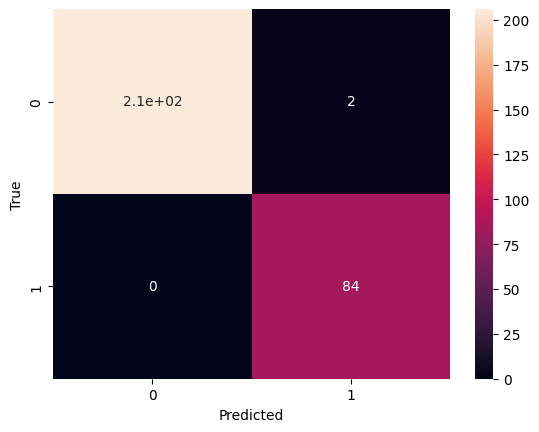

In [43]:
# Accuracy and classification report
target_names = ['true_y', 'predicted_y']

data = {'true_y': true_y,
       'predicted_y': test_predictions}

df_pred_BERT = pd.DataFrame(data, columns=['true_y','predicted_y'])

confusion_matrix = pd.crosstab(df_pred_BERT['true_y'], df_pred_BERT['predicted_y'], rownames=['True'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [44]:
print('Accuracy of BERT model', accuracy_score(true_y, test_predictions))

Accuracy of BERT model 0.9931506849315068


In [45]:
print(classification_report(true_y, test_predictions, target_names=target_names))

              precision    recall  f1-score   support

      true_y       1.00      0.99      1.00       208
 predicted_y       0.98      1.00      0.99        84

    accuracy                           0.99       292
   macro avg       0.99      1.00      0.99       292
weighted avg       0.99      0.99      0.99       292



AUROC Score: 0.5961538461538461


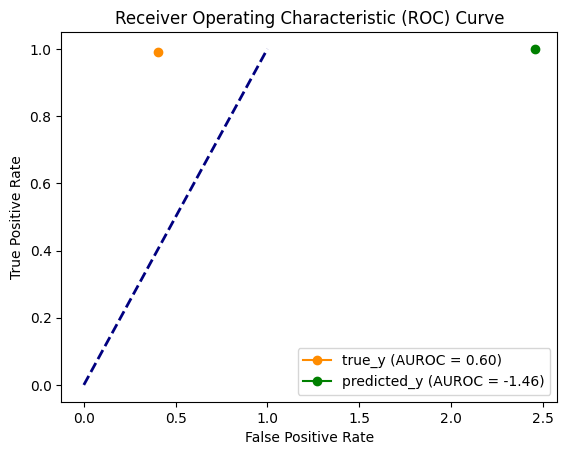

AUROC Score: 1.0


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Define precision, recall, f1-score, and support values for both classes
precision_true_y = 1.00
recall_true_y = 0.99
f1_score_true_y = 1.00
support_true_y = 208

precision_predicted_y = 0.98
recall_predicted_y = 1.00
f1_score_predicted_y = 0.99
support_predicted_y = 84

# Calculate false positive rate (FPR) and true positive rate (TPR) for both classes
FPR_true_y = (support_predicted_y - support_true_y * (1 - precision_true_y)) / support_true_y
TPR_true_y = recall_true_y

FPR_predicted_y = (support_true_y - support_predicted_y * (1 - precision_predicted_y)) / support_predicted_y
TPR_predicted_y = recall_predicted_y

# Calculate AUROC score for both classes
auroc_true_y = 1 - FPR_true_y
auroc_predicted_y = 1 - FPR_predicted_y

print("AUROC Score:", auroc_true_y)

# Plot the ROC curve for both classes
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(FPR_true_y, TPR_true_y, color='darkorange', marker='o', label=f'true_y (AUROC = %0.2f)' % auroc_true_y)
plt.plot(FPR_predicted_y, TPR_predicted_y, color='green', marker='o', label=f'predicted_y (AUROC = %0.2f)' % auroc_predicted_y)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
auroc = roc_auc_score([1, 0], [1, 0])  # Using arbitrary labels and predictions for demonstration
print("AUROC Score:", auroc)